# LSTM Forcast Stock v1

single value feature

In [1]:
%matplotlib inline
from pandas_datareader import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
print(sys.version_info)
print(tf.__version__)

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
1.3.0


## Get Google Stock data from google finance

In [2]:
# It seems that it only offer the data of the full last year by default,
# Correct it if you can get more data
goog = data.DataReader('GOOG', start='2010', end = "2017",
                       data_source='google')
goog.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2016-10-17,779.80,785.85,777.50,779.96,1092973
2016-10-18,787.85,801.61,785.56,795.26,2056903
2016-10-19,798.86,804.63,797.64,801.56,1766798
2016-10-20,803.30,803.97,796.03,796.97,1757528
2016-10-21,795.00,799.50,794.00,799.37,1266181
2016-10-24,804.90,815.18,804.82,813.11,1697514
2016-10-25,816.68,816.68,805.14,807.67,1576404
2016-10-26,806.34,806.98,796.32,799.07,1647733
2016-10-27,801.00,803.49,791.50,795.35,2749221


In [3]:
goog.to_csv("../datas/google_stock.csv")

### Prepare data

Use the Close value as data sample

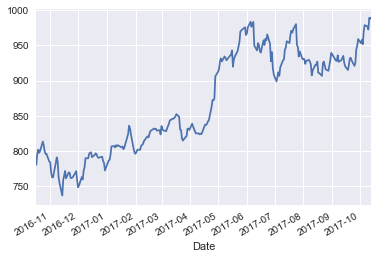

In [4]:
t_data: pd.Series = goog["Close"]
import seaborn
seaborn.set()
t_data.plot()

In [5]:
normalized_data = (t_data - t_data.mean())/ t_data.std()
normalized_data = normalized_data[:, np.newaxis]  # expand dimension

In [6]:
# Generate test data set

time_step: int = 20
rnn_unit: int = 10
batch_size: int = 60
input_size: int = 1
output_size: int = 1
learning_rate: float = 0.0006

train_x,train_y=[],[]   #traing set
for i in range(len(normalized_data)-time_step-1): ## This is ugly!
    x=normalized_data[i:i+time_step]
    y=normalized_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist()) 
    
train_x = np.array(train_x)
train_y = np.array(train_y)
train_x.shape # (-1, time_step, 1)

(230, 20, 1)

## Define NN Parameters

In [7]:
X=tf.placeholder(tf.float32, [None,time_step,input_size])    #Input tensor
Y=tf.placeholder(tf.float32, [None,time_step,output_size])   #Label Tensor

#weights, bias
weights={
         'in':  tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out': tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':    tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':   tf.Variable(tf.constant(0.1,shape=[1,]))
        }

## Define LSTM Network

In [8]:
def lstm(batch: int):  
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [9]:
def train_lstm():
    global batch_size
    pred, _ = lstm(batch_size)
    #Lost function
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(learning_rate).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #
        for i in range(10000):
            step=0
            start=0
            end=start+batch_size
            while(end<len(train_x)):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                start+=batch_size
                end=start+batch_size
                # 
                if i % 100 == 0 and step%10==0:
                    print(i,step,loss_)
                    print("Save Model:",saver.save(sess,'stock.model'))
                step+=1

In [10]:
train_lstm()

0 0 0.646594
Save Model： stock.model
100 0 0.0301775
Save Model： stock.model
200 0 0.0217941
Save Model： stock.model
300 0 0.0175115
Save Model： stock.model
400 0 0.0153061
Save Model： stock.model
500 0 0.0142083
Save Model： stock.model
600 0 0.0137025
Save Model： stock.model
700 0 0.0134916
Save Model： stock.model
800 0 0.0133987
Save Model： stock.model
900 0 0.0133474
Save Model： stock.model
1000 0 0.0133118
Save Model： stock.model
1100 0 0.0132823
Save Model： stock.model
1200 0 0.0132523
Save Model： stock.model
1300 0 0.0132149
Save Model： stock.model
1400 0 0.0131624
Save Model： stock.model
1500 0 0.0130925
Save Model： stock.model
1600 0 0.0130059
Save Model： stock.model
1700 0 0.0129081
Save Model： stock.model
1800 0 0.0128035
Save Model： stock.model
1900 0 0.0126981
Save Model： stock.model
2000 0 0.0125847
Save Model： stock.model
2100 0 0.0124678
Save Model： stock.model
2200 0 0.0123487
Save Model： stock.model
2300 0 0.0122438
Save Model： stock.model
2400 0 0.0121517
Save Model： 

In [10]:
def prediction():
    pred,_=lstm(1)      #
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #
        module_file = tf.train.latest_checkpoint(".")
        saver.restore(sess, module_file) 

        #
        prev_seq=train_x[-1]
        predict=[]
        #
        for i in range(100):
            next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
            predict.append(next_seq[-1])
            #
            prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
        #
        plt.plot(list(range(len(normalized_data))), normalized_data, color='b')
        plt.plot(list(range(len(normalized_data), len(normalized_data) + len(predict))), predict, color='r')


INFO:tensorflow:Restoring parameters from ./stock.model


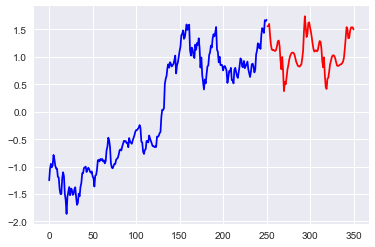

In [11]:
prediction()